In [49]:
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

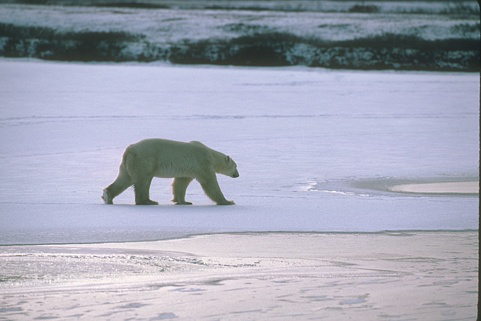

In [44]:
img = Image.open('dataset/images/test/100007.jpg')
img

In [7]:
img.size

(481, 321)

In [207]:
r = 2
def downscale(img): 
    img = tf.image.rgb_to_yuv(img)
    last_dimension_axis = len(img.shape) - 1
    y, u, v = tf.split(img, 3, axis=last_dimension_axis)
    out = tf.image.resize(y,[300//r,300//r]) / 255.0
    return out/255.0


In [208]:
def normalize(img):
    img = tf.image.rgb_to_yuv(img)
    last_dimension_axis = len(img.shape) - 1
    y, u, v = tf.split(img, 3, axis=last_dimension_axis)
    return y/255.0

In [209]:
normalize(img)

ValueError: Attempt to convert a value (<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=481x321 at 0x2021D11CEB0>) with an unsupported type (<class 'PIL.JpegImagePlugin.JpegImageFile'>) to a Tensor.

In [210]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory = "dataset/images/train",
    labels = None,
    shuffle=True,
    color_mode = 'grayscale',
    seed=42,
    image_size=(300,300)
)

Found 200 files belonging to 1 classes.


In [211]:
dataset = dataset.map(lambda x : (downscale(x),normalize(x)))

In [212]:
dataset

<MapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None))>

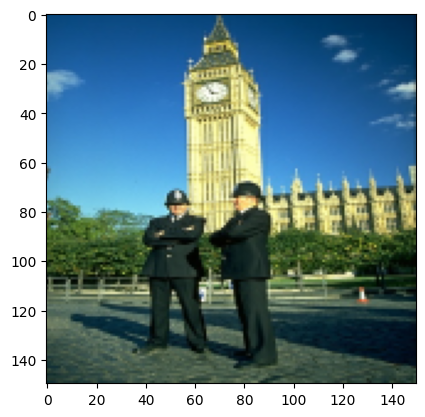

In [167]:
plt.imshow(np.clip(l[0][]* 255.0,0,255).astype('uint8'))

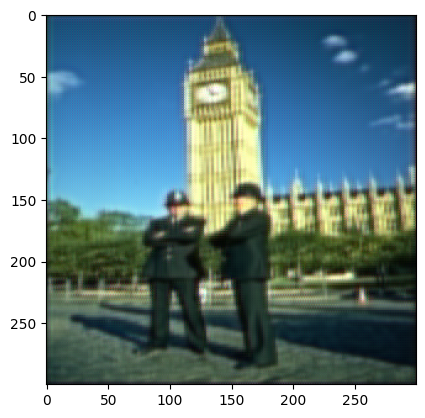

In [187]:
plt.imshow(np.clip(out[0]* 255.0,0,255).astype('uint8'))

In [213]:
channels = 1
r = 2

def depth_to_space(x, block_size):
    return tf.nn.depth_to_space(x, block_size=block_size)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64,3,activation='relu',padding='same',input_shape=(150,150,channels)))
model.add(tf.keras.layers.Conv2D(64, 3, padding='same',activation='relu'))
model.add(tf.keras.layers.Conv2D(32, 3, padding='same',activation='relu'))
model.add(tf.keras.layers.Conv2D(channels * (r ** 2), 3, padding='same',activation='relu'))
model.add(tf.keras.layers.Lambda(lambda x: depth_to_space(x, block_size=r), name='depth_to_space'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 150, 150, 64)      640       
                                                                 
 conv2d_33 (Conv2D)          (None, 150, 150, 64)      36928     
                                                                 
 conv2d_34 (Conv2D)          (None, 150, 150, 32)      18464     
                                                                 
 conv2d_35 (Conv2D)          (None, 150, 150, 4)       1156      
                                                                 
 depth_to_space (Lambda)     (None, 300, 300, 1)       0         
                                                                 
Total params: 57,188
Trainable params: 57,188
Non-trainable params: 0
_________________________________________________________________


In [206]:
def custom_loss(y_true, y_pred):
    # Ensure data types are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Mean Squared Error (MSE) loss
    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return loss

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=custom_loss,metrics=['accuracy'])

# Example usage of the compiled model with the dataset
model.fit(dataset,epochs=10,)

Epoch 1/10


InvalidArgumentError: Graph execution error:

2 root error(s) found.
  (0) INVALID_ARGUMENT:  Matrix size-incompatible: In[0]: [2880000,1], In[1]: [3,3]
	 [[{{node Tensordot_1/MatMul}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Matrix size-incompatible: In[0]: [2880000,1], In[1]: [3,3]
	 [[{{node Tensordot_1/MatMul}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_5201]

In [215]:
import tensorflow as tf

import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [249]:

def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)
model = get_model(upscale_factor=3)
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_64 (Conv2D)          (None, None, None, 64)    1664      
                                                                 
 conv2d_65 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 conv2d_66 (Conv2D)          (None, None, None, 32)    18464     
                                                                 
 conv2d_67 (Conv2D)          (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space_7 (TFO  (None, None, None, 1)    0         
 pLambda)                                                        
                                                           

In [250]:
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss=loss_fn,metrics=['accuracy'])

In [251]:
model.fit(train_ds.prefetch(32),epochs=10)

Epoch 1/10
25/25 [==============================] - 6s 88ms/step - loss: 0.0627 - accuracy: 0.0011
Epoch 2/10
25/25 [==============================] - 2s 87ms/step - loss: 0.0313 - accuracy: 0.0012
Epoch 3/10
25/25 [==============================] - 2s 78ms/step - loss: 0.0077 - accuracy: 0.0013
Epoch 4/10
25/25 [==============================] - 2s 68ms/step - loss: 0.0048 - accuracy: 0.0013
Epoch 5/10
25/25 [==============================] - 2s 77ms/step - loss: 0.0038 - accuracy: 0.0013
Epoch 6/10
25/25 [==============================] - 2s 79ms/step - loss: 0.0034 - accuracy: 0.0013
Epoch 7/10
25/25 [==============================] - 2s 63ms/step - loss: 0.0032 - accuracy: 0.0013
Epoch 8/10
25/25 [==============================] - 2s 84ms/step - loss: 0.0031 - accuracy: 0.0013
Epoch 9/10
25/25 [==============================] - 2s 70ms/step - loss: 0.0029 - accuracy: 0.0013
Epoch 10/10
25/25 [==============================] - 2s 80ms/step - loss: 0.0029 - accuracy: 0.0013


In [234]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


In [235]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    'dataset/images/train',
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    seed=1337,
    label_mode=None,
)

Found 200 files belonging to 1 classes.


In [236]:
train_ds = train_ds.map(scaling)

In [237]:

# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

In [242]:

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_56 (Conv2D)          (None, None, None, 64)    1664      
                                                                 
 conv2d_57 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 conv2d_58 (Conv2D)          (None, None, None, 32)    18464     
                                                                 
 conv2d_59 (Conv2D)          (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space_5 (TFO  (None, None, None, 1)    0         
 pLambda)                                                        
                                                           

In [258]:
out = model.predict([list(train_ds)[0][0][0]])

4/4 [==============================] - 0s 8ms/step


In [260]:
out.shape

(100, 300, 3, 1)

In [261]:
process_target(out)

InvalidArgumentError: {{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:GPU:0}} Matrix size-incompatible: In[0]: [90000,1], In[1]: [3,3] [Op:MatMul]